# Earnings Beat or Earnings Miss Predictor
This GNN model will predict whether a company will beat or miss the next quarters earnings estimate based on fanancial data entered at the end of current quarter. <br>
**Concept:** Each quarter publicly traded companies release their earnings for the quarter.  Some of those companies will also releast expected earnings. Analysts may also produce expected earnings for a company. If a company signifiantly beats its earnings, then the stock price ususally will rise. The question for this analysis is, can we find features and graph relationships between companies that have some predictive information to anticipate whether the next quarter's earnings will be significatly higher, lower or the same as the expected earnings estimate? An investment strategy would be then to buy the companies that are expected to significatly beat their estimates, or possibly sell short the companies that expected to significantly miss their estimate. Basically, we want to identify surprises. Historically, There is about 4.5% underestimate of expectations for the S&P500. So we want to adjust the definition of a surprise to reflect the underestimation since the market investors will also recalibrate expectations. 

-  lt -5%       -> 0
-  [-5%, 15%]   -> 1
-  gt 15%       -> 2

In [1]:
import torch
import torch.nn as nn
import torch_geometric.nn as gnn
import torch_geometric.data as gdata
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import datetime as dt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import time
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:

def populate_node_target_features(ticker: str, node_grp: h5py.Group, target_grp: h5py.Group, n_quarters: int) -> None:
    # Get the data from the API 
    # Data dimension is [num_quarters, num_features] per company

    # Get all the quarterly data from the API for the company
    api_functions = ['EARNINGS', 'INCOME_STATEMENT', 'BALANCE_SHEET', 'CASH_FLOW', 'TIME_SERIES_MONTHLY_ADJUSTED']
    data = dict()
    for api_function in api_functions:
    
        url = f'https://www.alphavantage.co/query?function={api_function}&symbol={ticker}&apikey={api_key}'
        try:
            r = requests.get(url)
            data[api_function] = r.json()
            # pause 1 seconds between requests to avoid hitting the API request limit
            time.sleep(0.5)
            
        except:
            print(f'Error retrieving {api_function} data from API for ')
            return
    
    # Extract the quarterly data 
    # Stack the quarterly data into a matrix
    node_matrix = np.zeros((n_quarters, n_features-1))
    target_matrix = np.zeros((n_quarters, 2))
    for qidx in range(n_quarters):
        # Get the features we want from the quarterly data
        features = []        
        # Income statement features
        income_statement = data['INCOME_STATEMENT']['quarterlyReports'][qidx]
        income_statement_features = [
            'totalRevenue',
            'operatingExpenses',
            'costofGoodsAndServicesSold',
            'ebitda',
            'operatingExpenses',
            'operatingIncome',
            'otherNonOperatingIncome',
            'researchAndDevelopment',
            'sellingGeneralAndAdministrative',
            'grossProfit',
            'interestExpense',
            'interestIncome',
        ]
        try:
            features.extend([income_statement[feature] for feature in income_statement_features])
        except:
            print(f'Error retrieving {feature} from income statement for {ticker}')
            return
        # Balance sheet features
        balance_sheet = data['BALANCE_SHEET']['quarterlyReports'][qidx]
        balance_sheet_features = [
            'totalAssets',
            'totalLiabilities',
            'commonStock',
            'currentAccountsPayable',
            'currentNetReceivables',
            'totalShareholderEquity',
            'currentDebt',
            'deferredRevenue',
            'inventory',
        ]
        try:
            features.extend([balance_sheet[feature] for feature in balance_sheet_features])
        except:
            print(f'Error retrieving {feature} from balance sheet for {ticker}')
            return
        # Cash flow features
        cash_flow = data['CASH_FLOW']['quarterlyReports'][qidx]
        cash_flow_features = [
            'profitLoss',
            'dividendPayout',
            'capitalExpenditures',
            'proceedsFromIssuanceOfCommonStock',
            'paymentsForRepurchaseOfCommonStock',
            'netIncome',            
        ]
        try:
            features.extend([cash_flow[feature] for feature in cash_flow_features]) 
        except:
            print(f'Error retrieving {feature} from cash flow for {ticker}')
            return       
        # Earnings features
        earnings = data['EARNINGS']['quarterlyEarnings'][qidx]
        earnings_features = [
            'estimatedEPS',
            'reportedEPS',
        ]
        try:
            features.extend([earnings[feature] for feature in earnings_features])  
        except:
            print(f'Error retrieving {feature} from earnings for {ticker}')
            return

        # Time series features
        time_series = data['TIME_SERIES_MONTHLY_ADJUSTED']['Monthly Adjusted Time Series']
        # Get the date of the quarter end
        quarter_end_date = earnings['fiscalDateEnding']  
        # Extract the year and month from the date and convert to integers
        year = int(quarter_end_date[:4])
        month = int(quarter_end_date[5:7])
        # Get the monthy adjusted close price for each of the three months of the quarter
        # Have to match year and month because the day is not end of the month
        for i in range(3):       
            # Find the price key for the year and month we can to get the price for     
            price_key = [date for date in time_series.keys() if date[:7] == f'{year}-{month:02d}'][0]
            month_adj_close_price = time_series[price_key]['5. adjusted close']
            features.append(month_adj_close_price)
            # convert date to previous month date for the next price
            price_date = dt.datetime.strptime(price_key, '%Y-%m-%d')
            prev_month_date = price_date - dt.timedelta(days=31)
            year = prev_month_date.year
            month = prev_month_date.month
            
        # Convert feature array to numpy array and divide quarterly features by a billion to scale them
        # Convert any 'none' strings in the features list to 0
        features = [None if feature == 'None' else feature for feature in features]        
        features = np.array(features, dtype=np.float32)
        features[:-5] /= 1.0e9
        # Store the features in the hdf5 file
        node_matrix[qidx, :] = features
        target_matrix[qidx, :] = np.array([earnings[feature] for feature in earnings_features], dtype=np.float32)
    node_grp[ticker] = node_matrix
    target_grp[ticker] = target_matrix
    

In [3]:

def populate_edge_features(pair: str, edge_grp: h5py.Group) -> None:
    # Get the data from the API
    # Data dimension is [1], one edge weight for each pair of companies

    # Get the company overview data for each of the companies in the pair
    (ticker1, ticker2) = pair.split('_')
    api_functions = ['OVERVIEW']
    data = dict()
    for ticker in (ticker1, ticker2):
        for api_function in api_functions:
            url = f'https://www.alphavantage.co/query?function={api_function}&symbol={ticker}&apikey={api_key}'
            try:
                r = requests.get(url)
                data[ticker] = r.json()
                time.sleep(0.5)
            except:
                print(f'Error retrieving {api_function} data from API')
                return
            
    # Get the features we want from the company overview data
    feature1 = []
    feature2 = []
    # Ticker 1 features
    feature1.extend([data[ticker1]['Sector'], data[ticker1]['Industry']])
    # Ticker 2 features
    feature2.extend([data[ticker2]['Sector'], data[ticker2]['Industry']])

    # create a feature string from each of the features
    feature1_str = ' '.join(feature1)
    feature2_str = ' '.join(feature2)

    # Use the sentence transformer to get the embeddings for the features
    model = SentenceTransformer('paraphrase-distilroberta-base-v1')
    feature1_embedding = model.encode(feature1_str)
    feature2_embedding = model.encode(feature2_str)
    # Convert the embeddings to a column vector
    feature1_embedding = feature1_embedding.reshape(1, -1)
    feature2_embedding = feature2_embedding.reshape(1, -1)    
    
    # Compute the cosine similarity between the embeddings
    edge_weight = cosine_similarity(feature1_embedding, feature2_embedding)

    # Store the edge weight in the hdf5 file
    edge_grp[pair] = edge_weight



In [4]:

def store_EBEMP_data(data_path: str, company_symbols: list, reprocess_features: bool) -> None:
    
    def process_nodes():
        # For each company check if it's new because we might add new companies to the list of companies we want to include in our GNN
        nbar = tqdm(company_symbols)
        for ticker in nbar:
            nbar.set_description(f'Processing {ticker} node features')
            if ticker not in node_grp.keys():
                
                populate_node_target_features(ticker, node_grp, target_grp, n_quarters)
                

    def process_edges():
        # Iterate through all unique pairs of companies and create a dataset for each pair if it doesn't exist to define the edge features
        # because there might be new ones in case they were added to the list of companies we want to include in our GNN
        ebar = tqdm(range(len(company_symbols)))
        for i in ebar:
            ebar.set_description(f'Processing {company_symbols[i]} edge features')
            for j in range(i+1, len(company_symbols)):
                pair = company_symbols[i] + '_' + company_symbols[j]
                if pair not in edge_grp.keys():
                    # If the edge pair is new, then compute the edge weight and create a hdf5 dataset to store it
                    
                    populate_edge_features(pair, edge_grp)
                   
    
    # Two main cases here: 1) We want to reprocess all the features, or 2) Features are the same but we added new companies to GNN
    if os.path.exists(data_path) and reprocess_features:
        print('Deleting old data and reprocessing features')
        # Opening the file in write mode deletes all the data
        EBEMP_data = h5py.File(data_path, 'w')

        # Create a node group, edge, target, groups in the hdf5 file if they don't exist
        node_grp = EBEMP_data.create_group('nodes')
        edge_grp = EBEMP_data.create_group('edges')
        target_grp = EBEMP_data.create_group('targets')
       
        process_nodes()

        process_edges()        


    else:
        # Opening the file in append mode allows us to add new data without deleting the old data or create a new file if it doesn't exist
        print('Appending new data to existing file or creating new file if it does not exist')
        EBEMP_data = h5py.File(data_path, 'a')
        # Create a node group, edge, target, groups in the hdf5 file if they don't exist
        if 'nodes' not in EBEMP_data.keys():
            node_grp = EBEMP_data.create_group('nodes')
        if 'edges' not in EBEMP_data.keys():
            edge_grp = EBEMP_data.create_group('edges')
        if 'targets' not in EBEMP_data.keys():
            target_grp = EBEMP_data.create_group('targets')
        node_grp = EBEMP_data['/nodes']
        edge_grp = EBEMP_data['/edges']
        target_grp = EBEMP_data['/targets']
        
        process_nodes()
               
        process_edges()

        
    #close the hdf5 file
    EBEMP_data.close()
    
    
        

## Define parameters for the model

In [98]:
# Specify the companies we want to include in our GNN
#dow_list = ['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'DOW', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'CRM', 'TRV', 'UTX', 'VZ', 'V', 'WBA', 'WMT', 'DIS']

# Gather and save the data we want to collect for each company so we don't have to do a lot of requests to the API
company_symbols = ['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']

# Alpha Vantage API key
api_key = 'IMSWKZZ2ILUS0FKX'
# Look for the data in the data folder
EBEMP_data_path = 'data/EBEMP_data_dow_11qtrs_20231120.hdf5'
# Specify the number of features we want to collect for each company
n_features = 33
# There will be multiple quarters of data for this graph, so we need to specify the number of quarters we want to include
n_quarters = 11
# Parameter that determines if companies are similar enough to be connected by an edge
edge_similarity_threshold = 0.5




# Get the EBEMP data
#store_EBEMP_data(data_path=EBEMP_data_path, company_symbols=company_symbols, reprocess_features=False)

## Generate training data from data file

In [99]:
## This Cell: Retreive the EBEMP data, organize it into a PyTorch Geometric Data object for train, val and test and then return the Data objects

# Open the hdf5 file for reading
EBEMP_data = h5py.File(EBEMP_data_path, 'r')
company_symbols = list(EBEMP_data['nodes'].keys())

node_grp = EBEMP_data['/nodes']
edge_grp = EBEMP_data['/edges']
target_grp = EBEMP_data['/targets']

# fiscal quarter indices for training, validation, and testing
# most reacent quarter is at index 0 but we need to use that data for the labels of the previous quarter
# so there is always at most n_quarters-1 quarters of data for training, validation, and testing

qtr_train = list(range(n_quarters-1, 2, -1)) 
qtr_val = list(range(n_quarters-1, 1, -1)) # validation is the second most recent quarter
qtr_test = list(range(n_quarters-1, 0, -1)) # testing is the second most recent quarter


#### Build the PyTorch Geometric Data object for the training data ####

## NODES and TARGETS ##
# Build the nodes, the newest quarters are at the beginning of the matrix so the qtr index counts backwards

def get_node_data(qtr_indices):
    nodes = []
    targets = []
    for qidx in qtr_indices:        
        for ticker in company_symbols:
            # Get the node features for the company
            nodes.append(node_grp[ticker][qidx, :])
            # Compute the score for the next quarter as ground truth for training
            estEPS = target_grp[ticker][qidx-1, 0]
            # add est EPS from current quarter to node features
            nodes[-1] = np.append(nodes[-1], estEPS)
            repEPS = target_grp[ticker][qidx-1, 1]
            EPSratio = repEPS/estEPS
            # map to one-hot output targets            
            if EPSratio < 1:
                score = 0
            elif EPSratio >= 1 and EPSratio < 1.05:
                score = 1
            elif EPSratio >= 1.05 and EPSratio < 1.15:
                score = 2
            else:
                score = 3
            targets.append(score)
    # Insert 0 for nan values in the node features
    nodes = np.array(nodes, dtype=np.float32)
    nodes[np.isnan(nodes)] = 0.0
    return nodes, targets

## EDGES ##
# For each quarter, there are edges between companies that are similar enough to be connected
# Companies in different quarters are just different nodes, but they have the same edges as the companies in the previous quarter
# But there are there needs to be an edge between the nodes in the previous quarter and the nodes in the current quarter for the same company
# the edges in the data file are undirected so we need to provide directed edges in both directions
# This code defines all the outgoing edges from each node in the graph

def get_edge_data(qtr_indices):
    # We need to define all the pairwise directed edges if the edge weight is above the similarity threshold
    edges_buf = []
    for cidx, ticker in enumerate(company_symbols):
        # edges can be out of order in the hdf5 file so we need to check both directions
        for eidx in range(len(company_symbols)):
            pair = ticker + '_' + company_symbols[eidx]
            if pair in edge_grp.keys():
                if edge_grp[pair][0] > edge_similarity_threshold:
                    edges_buf.append([cidx, eidx])
            # The ordering of the edge labels is unpredictable so we need to check both directions
            pair = company_symbols[eidx] + '_' + ticker
            if pair in edge_grp.keys():
                if edge_grp[pair][0] > edge_similarity_threshold:
                    edges_buf.append([cidx, eidx])
    #edges_buf = []
    # Each quarter of financial data basically repesents a layer of nodes that are connected.  The subsequent
    # quarter is another layer with the same connections but different node indices.  So we just need to duplicate
    # the node list with an offset for each quarter.
    # Then we need to create a directed edge from older quarters to newer quarters nodes, so earlier node indices to 
    # later node indices
    edges=[]
    edges_cross_qtr = []
    for i, qidx in enumerate(qtr_indices):
        offset = i*len(company_symbols)
        edges.extend([[edge[0]+offset,edge[1]+offset] for edge in edges_buf])
        
    for i, qidx in enumerate(qtr_indices[:-1]):
        offset = i*len(company_symbols)    
        # create directed edges from older quarters to newer quarters nodes
        offset_plus = (i+1)*len(company_symbols)
        edges_cross_qtr.extend([[j+offset,j+offset_plus] for j in range(len(company_symbols))])
    # Now put attach the cross quarter edges to the end of the full training edges
    edges.extend(edges_cross_qtr)
    return edges

## Train data ##
# Normalize the node features
scaler = StandardScaler()

nodes_train, targets_train = get_node_data(qtr_train)
scaler.fit(nodes_train)
norm_nodes_train = scaler.transform(nodes_train)

edges_train = get_edge_data(qtr_train)

x = torch.tensor(np.array(norm_nodes_train), dtype=torch.float)
y = torch.tensor(np.array(targets_train), dtype=torch.long)
edge_index = torch.tensor(np.array(edges_train), dtype=torch.long).t().contiguous()

data_train = gdata.Data(x=x, y=y, edge_index=edge_index)

## Val data ##

nodes_val, targets_val = get_node_data(qtr_val)
norm_nodes_val = scaler.transform(nodes_val)

edges_val = get_edge_data(qtr_val)

x = torch.tensor(np.array(norm_nodes_val), dtype=torch.float)
y = torch.tensor(np.array(targets_val), dtype=torch.long)
edge_index = torch.tensor(np.array(edges_val), dtype=torch.long).t().contiguous()

data_val = gdata.Data(x=x, y=y, edge_index=edge_index)

## Test data ##
nodes_test, targets_test = get_node_data(qtr_test)
norm_nodes_test = scaler.transform(nodes_test)

edges_test = get_edge_data(qtr_test)

x = torch.tensor(np.array(norm_nodes_test), dtype=torch.float)
y = torch.tensor(np.array(targets_test), dtype=torch.long)
edge_index = torch.tensor(np.array(edges_test), dtype=torch.long).t().contiguous()

data_test = gdata.Data(x=x, y=y, edge_index=edge_index)

# Now we can close the data file
EBEMP_data.close()


## Data statistics
Note that it is very common for companies to give estimated EPS that is low in order to regularly beat the EPS estimate. Fro the S&P 500 the average EPS estimate is aroudn 7% too low historically. Interestingly, this means that people expect earnings beats by around 7% on average so we expect to see this in the training data distribution. 

In [100]:
print(f'Number of nodes in training data: {data_train.num_nodes}')
print(f'Number of edges in training data: {data_train.num_edges}')
print(f'Number of nodes in validation data: {data_val.num_nodes}')
print(f'Number of edges in validation data: {data_val.num_edges}')
print(f'Number of nodes in testing data: {data_test.num_nodes}')
print(f'Number of edges in testing data: {data_test.num_edges}')
# Print the counts of each of the three classes in the training data
print(f'Number of class 0 nodes in training data: {torch.sum(data_train.y == 0)}')
print(f'Number of class 1 nodes in training data: {torch.sum(data_train.y == 1)}')
print(f'Number of class 2 nodes in training data: {torch.sum(data_train.y == 2)}')
print(f'Number of class 3 nodes in training data: {torch.sum(data_train.y == 3)}')

for i in range(10):
    print(company_symbols[edges_train[i][0]], company_symbols[edges_train[i][1]])


Number of nodes in training data: 240
Number of edges in training data: 1474
Number of nodes in validation data: 270
Number of edges in validation data: 1662
Number of nodes in testing data: 300
Number of edges in testing data: 1850
Number of class 0 nodes in training data: 26
Number of class 1 nodes in training data: 82
Number of class 2 nodes in training data: 75
Number of class 3 nodes in training data: 57
AAPL CAT
AAPL CRM
AAPL CSCO
AAPL IBM
AAPL MSFT
AAPL VZ
AMGN DOW
AMGN INTC
AMGN JNJ
AMGN MMM


## Training the GNN

In [117]:
import torch.nn.functional as F

class EBEM_GNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = gnn.GCNConv(data_train.num_node_features, 33)
        self.conv2 = gnn.GCNConv(33, 33)
        self.conv3 = gnn.GCNConv(33, 4)
        self.conv4 = gnn.GCNConv(32, 32)
        self.conv5 = gnn.GCNConv(32, 32)
        self.conv6 = gnn.GCNConv(32, data_train.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training, p=0)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training, p=0)
        x = self.conv3(x, edge_index)
        # x = F.relu(x)
        # x = F.dropout(x, training=self.training, p=0)
        # x = self.conv4(x, edge_index)
        # x = F.relu(x)
        # x = F.dropout(x, training=self.training, p=0)
        # x = self.conv5(x, edge_index)
        # x = F.relu(x)
        # x = F.dropout(x, training=self.training, p=0)
        # x = self.conv6(x, edge_index)


        return F.log_softmax(x, dim=1)

In [124]:
data_train.num_classes = 4
model = EBEM_GNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_losses = []
val_losses = []


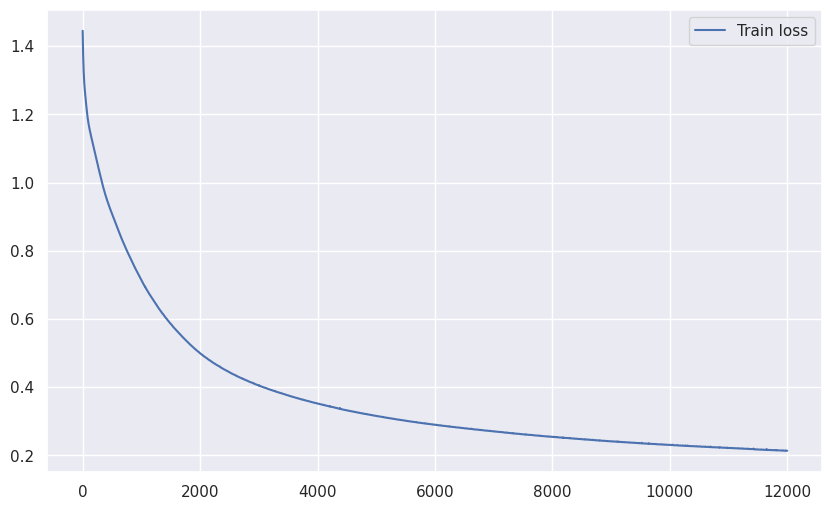

In [127]:


# capture the training loss and plot it
for epoch in range(4000):
    model.train()
    optimizer.zero_grad()
    out = model(data_train)
    loss = F.nll_loss(out, data_train.y)
    loss.backward()
    optimizer.step()
    #print('Epoch: {:03d}, Loss: {:.5f}'.format(epoch, loss.item()))
    train_losses.append(loss.item())
    
    # capture the validation loss and plot it
    model.eval()
    val_out = model(data_val)
    val_loss = F.nll_loss(val_out[-30:], data_val.y[-30:])
    val_losses.append(val_loss.item())

# plot the train and val losses on the same plot
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train loss')
#plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

Accuracy: 0.46667
[[ 5  9  6  8]
 [ 6 39 18  4]
 [ 4 19 25  8]
 [ 9  1  4 15]]


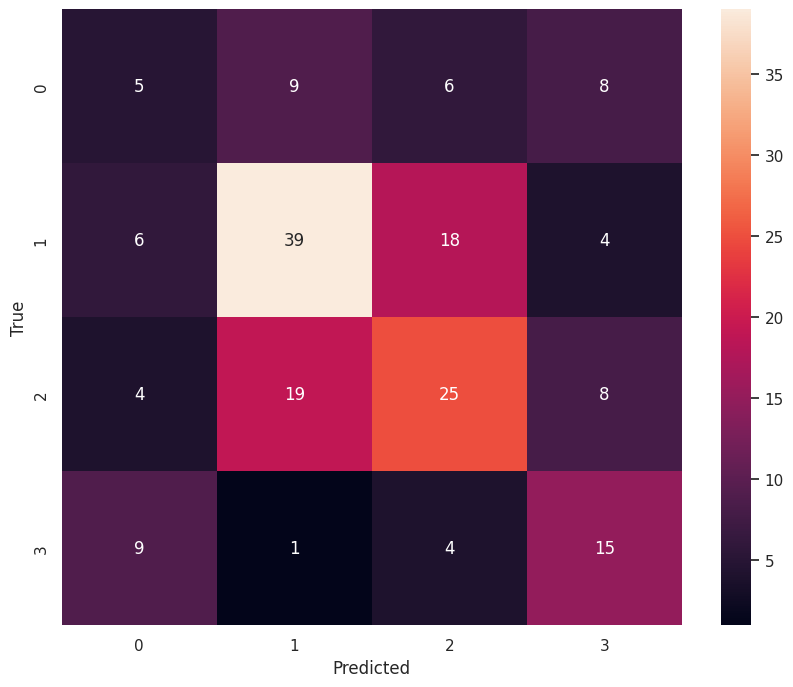

              precision    recall  f1-score   support

           0       0.21      0.18      0.19        28
           1       0.57      0.58      0.58        67
           2       0.47      0.45      0.46        56
           3       0.43      0.52      0.47        29

    accuracy                           0.47       180
   macro avg       0.42      0.43      0.42       180
weighted avg       0.46      0.47      0.46       180



In [128]:
# Compute the accuracy on the training data
n_layers = 2
n_eval_nodes = len(company_symbols) * (len(qtr_train) - n_layers)

model.eval()
_, pred = model(data_train).max(dim=1)
train_pred = pred[-n_eval_nodes:]
data_train_y = data_val.y[-n_eval_nodes:]
correct = float(train_pred.eq(data_train_y).sum().item())
acc = correct / len(data_train_y)
print('Accuracy: {:.5f}'.format(acc))

# Get the confusion matrix for the training data
y_true = data_train_y.numpy()
y_pred = train_pred.numpy()
cm = confusion_matrix(y_true, y_pred)
print(cm)

# plot the confusion matrix

sns.set()
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Get the classification report for the training data
print(classification_report(y_true, y_pred, target_names=['0', '1', '2', '3']))


Accuracy: 0.33333
[[1 3 0 3]
 [1 8 0 0]
 [3 8 0 0]
 [1 1 0 1]]


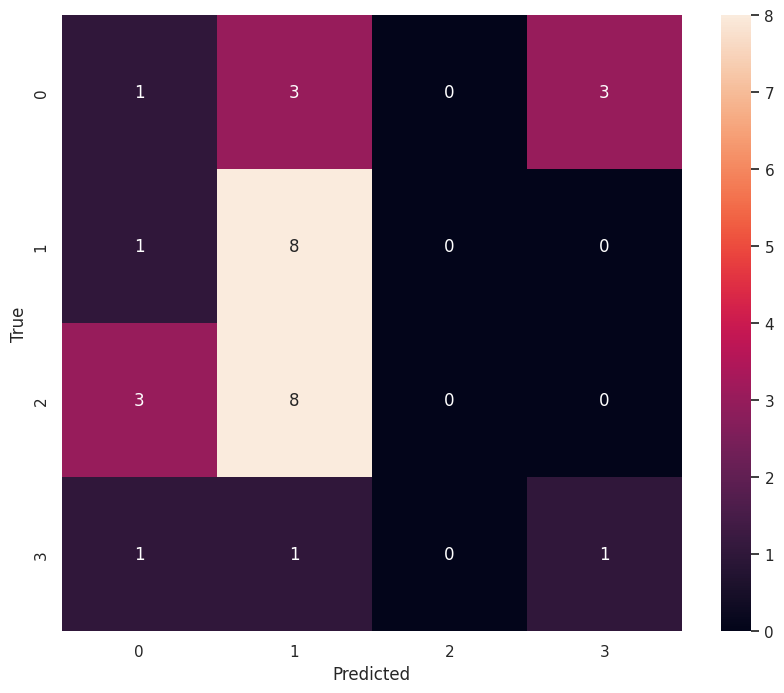

ValueError: Number of classes, 4, does not match size of target_names, 3. Try specifying the labels parameter

In [129]:
# compute the accuracy on the validation data
model.eval()
_, pred = model(data_val).max(dim=1)
val_pred = pred[-30:]
data_val_y = data_val.y[-30:]
val_hold = val_pred.eq(data_val_y)
correct = float(val_hold.sum().item())
acc = correct / len(data_val_y)
print('Accuracy: {:.5f}'.format(acc))

# Get the confusion matrix for the validation data
y_true = data_val_y.numpy()
y_pred = val_pred.numpy()
cm = confusion_matrix(y_true, y_pred)
print(cm)

# plot the confusion matrix

sns.set()
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Get the classification report for the training data
print(classification_report(y_true, y_pred, target_names=['0', '1', '2', '3']))